In [1]:
import pvdeg
import matplotlib.pyplot as plt
import numpy as np

import pandas as pd
import pickle

In [2]:
locationGetter = pvdeg.scenario.GeospatialScenario()

locationGetter.addLocation(
    country="United States",
    downsample_factor=80,
    nsrdb_attributes=pvdeg.pysam.INSPIRE_NSRDB_ATTRIBUTES,
)

/home/tford/.conda-envs/rpp/lib/python3.10/site-packages/xarray/core/dataset.py:274: UserWarning: The specified chunks separate the stored chunks along dimension "phony_dim_1" starting at index 500. This could degrade performance. Instead, consider rechunking after loading.
  warnings.warn(


In [3]:
locationGetter.weather_data

<xarray.Dataset> Size: 1TB
Dimensions:            (time: 8760, gid: 2018267)
Coordinates:
  * gid                (gid) int64 16MB 0 1 2 3 ... 2018264 2018265 2018266
  * time               (time) datetime64[ns] 70kB 2023-01-01T00:30:00 ... 202...
Data variables:
    temp_air           (time, gid) float64 141GB dask.array<chunksize=(8760, 500), meta=np.ndarray>
    wind_speed         (time, gid) float64 141GB dask.array<chunksize=(8760, 500), meta=np.ndarray>
    wind_direction     (time, gid) float64 141GB dask.array<chunksize=(8760, 500), meta=np.ndarray>
    dhi                (time, gid) float64 141GB dask.array<chunksize=(8760, 500), meta=np.ndarray>
    ghi                (time, gid) float64 141GB dask.array<chunksize=(8760, 500), meta=np.ndarray>
    dni                (time, gid) float64 141GB dask.array<chunksize=(8760, 500), meta=np.ndarray>
    relative_humidity  (time, gid) float64 141GB dask.array<chunksize=(8760, 500), meta=np.ndarray>
    albedo             (time, gid) float64 141GB dask.array<chunksize=(8760, 500), meta=np.ndarray>
Attributes:
    version:  4.0.1

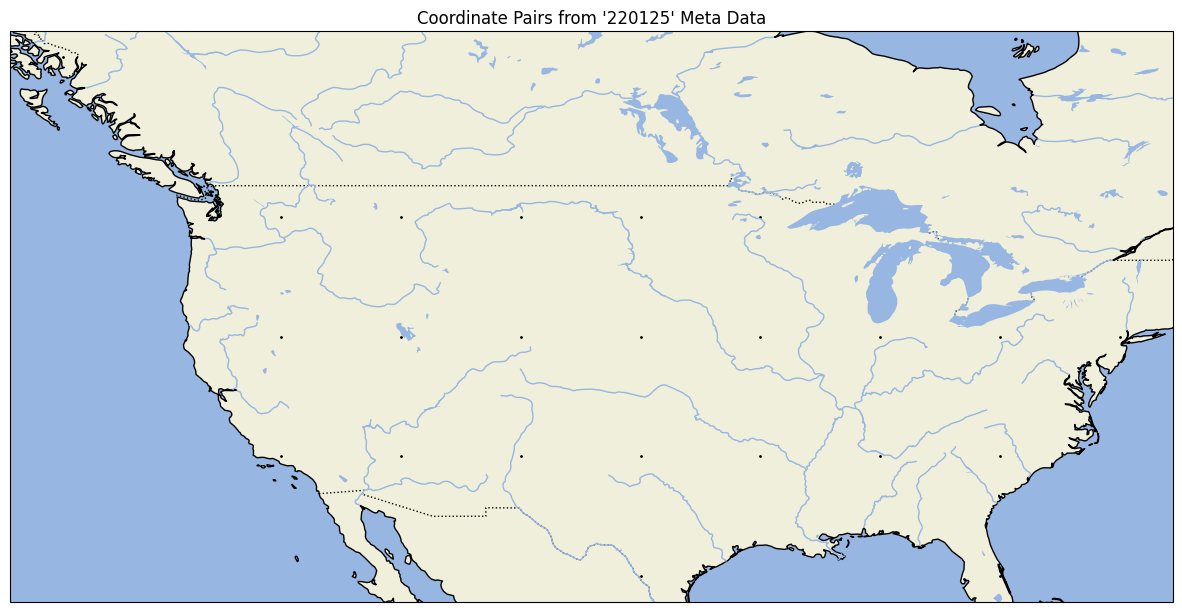

In [4]:
locationGetter.plot_coords()

In [5]:
geo_weather, geo_meta = locationGetter.geospatial_data()

geo_meta = geo_meta[geo_meta["state"] != "Alaska"]
geo_weather = geo_weather.sel(gid=geo_meta.index)

In [ ]:
shapes = {"annual_poa": ("gid",), "ground_irradiance": ("gid", "time", "distance")}

template = pvdeg.geospatial.output_template(
    ds_gids=geo_weather,
    shapes=shapes,
    add_dims={
        "distance": 10
    },  # this will autogenerate a range of length 10 for the coordinate axis
)

In [ ]:
pysam_fake_res = pvdeg.geospatial.analysis(
    weather_ds=geo_weather,
    meta_df=geo_meta,
    func=pvdeg.pysam.sample_pysam_result,  # this doesnt actually calculate using pysam, returns duplicate saved pysam sim value each time it is called
    template=template,
)

In [ ]:
# this plot is not great because there are a lot of rows with zero values
# each line represents the temperature at a fixed distance over time.
plt.plot(pysam_fake_res.isel(latitude=0, longitude=3)["ground_irradiance"])

In [ ]:
single_location_irradiance = pysam_fake_res.isel(latitude=0, longitude=3)[
    "ground_irradiance"
]

plt.figure(figsize=(6, 18))

plt.imshow(
    single_location_irradiance, aspect="auto", cmap="viridis", interpolation="nearest"
)
plt.colorbar()

In [ ]:
pysam_fake_res.isel(latitude=0, longitude=3)["ground_irradiance"]

In [ ]:
nonzero_mask = np.any(single_location_irradiance != 0, axis=1).compute()

nonzero_da = pysam_fake_res.isel(latitude=0, longitude=3)["ground_irradiance"].isel(
    time=nonzero_mask
)

In [ ]:
plt.figure(figsize=(10, 6))
plt.scatter(np.arange(nonzero_da.sizes["time"]), nonzero_da.time, s=0.1)

This appears to happen because the model only calculates given certain constraints. We take less calculations near the end of the year and more in the center. We can probably ignore this safely and simply take a monthly average.

In [ ]:
plt.figure(figsize=(6, 18))

plt.imshow(nonzero_da, aspect="auto", cmap="viridis", interpolation="nearest")
plt.colorbar()

In [ ]:
nonzero_da

In [ ]:
month_ground_irradiance = nonzero_da.groupby(nonzero_da.time.dt.month).mean()

In [ ]:
# this plot does not have labels but each line represents the avg irradiance at a
# fixed distance from the array for each month

plt.plot(month_ground_irradiance)

In [ ]:
pd.date_range(start="2001-01-01", periods=8760, freq="1h").year

In [6]:
weather_df = geo_weather.isel(gid=0).to_dataframe()
meta_dict = geo_meta.iloc[0].to_dict()

# path to files
# 01 - 10
options = ["01", "02", "03", "04", "05", "06", "07", "08", "09", "10"]

config_dict = {
    option: f"/home/tford/dev/InSPIRE/Studies/USMap_Doubleday_2024/SAM/{option}/{option}_pvsamv1.json"
    for option in options
}

config_dict

{'01': '/home/tford/dev/InSPIRE/Studies/USMap_Doubleday_2024/SAM/01/01_pvsamv1.json',
 '02': '/home/tford/dev/InSPIRE/Studies/USMap_Doubleday_2024/SAM/02/02_pvsamv1.json',
 '03': '/home/tford/dev/InSPIRE/Studies/USMap_Doubleday_2024/SAM/03/03_pvsamv1.json',
 '04': '/home/tford/dev/InSPIRE/Studies/USMap_Doubleday_2024/SAM/04/04_pvsamv1.json',
 '05': '/home/tford/dev/InSPIRE/Studies/USMap_Doubleday_2024/SAM/05/05_pvsamv1.json',
 '06': '/home/tford/dev/InSPIRE/Studies/USMap_Doubleday_2024/SAM/06/06_pvsamv1.json',
 '07': '/home/tford/dev/InSPIRE/Studies/USMap_Doubleday_2024/SAM/07/07_pvsamv1.json',
 '08': '/home/tford/dev/InSPIRE/Studies/USMap_Doubleday_2024/SAM/08/08_pvsamv1.json',
 '09': '/home/tford/dev/InSPIRE/Studies/USMap_Doubleday_2024/SAM/09/09_pvsamv1.json',
 '10': '/home/tford/dev/InSPIRE/Studies/USMap_Doubleday_2024/SAM/10/10_pvsamv1.json'}

We run two different configs out of the 10 provided. The annual POA appears the same for these configs but the ground irradiance values are different as shown below. The distance indicies are not the real indexes.

In [ ]:
config_files1 = {"pv": config_dict["01"]}
config_files2 = {"pv": config_dict["02"]}

res1 = pvdeg.pysam.inspire_ground_irradiance(weather_df, meta_dict, config_files1)
res2 = pvdeg.pysam.inspire_ground_irradiance(weather_df, meta_dict, config_files2)

In [12]:
res1

<xarray.Dataset> Size: 1MB
Dimensions:              (time: 8760, distance: 10)
Coordinates:
  * time                 (time) datetime64[ns] 70kB 2001-01-01T00:30:00 ... 2...
  * distance             (distance) int64 80B 0 1 2 3 4 5 6 7 8 9
Data variables:
    annual_poa           float64 8B 8.306e+05
    annual_energy        float64 8B 1.385e+05
    poa_front            (time) float64 70kB dask.array<chunksize=(8760,), meta=np.ndarray>
    poa_rear             (time) float64 70kB dask.array<chunksize=(8760,), meta=np.ndarray>
    subarray1_poa_front  (time) float64 70kB dask.array<chunksize=(8760,), meta=np.ndarray>
    subarray1_poa_rear   (time) float64 70kB dask.array<chunksize=(8760,), meta=np.ndarray>
    ground_irradiance    (time, distance) float64 701kB dask.array<chunksize=(8760, 10), meta=np.ndarray>

In [ ]:
mask = np.any(ds1.ground_irradiance != 0, axis=1)

nonzero = ds1.ground_irradiance.compute()[mask.compute()]

nonzero.compute()

In [ ]:
mask = np.any(ds2.ground_irradiance != 0, axis=1)

nonzero = ds2.ground_irradiance.compute()[mask.compute()]

nonzero.compute()

In [ ]:
#####

# the following cells were for sharing with silvana for the size of the xarray
# we were using 30 minute 2022 data (not tmy) so i sliced it to be the correct size of TMY data

#####

In [ ]:
sliced_data = pysam_fake_res.isel(latitude=0, longitude=3).isel(time=slice(8760))

# Specify the file where the pickled data will be stored
pickle_file = "sliced_data.pkl"

# Pickle the data
with open(pickle_file, "wb") as f:
    pickle.dump(sliced_data, f)

print(f"Data has been pickled and saved to {pickle_file}")

In [ ]:
import pickle

with open("sliced_data.pkl", "rb") as f:
    loaded_data = pickle.load(f)

In [ ]:
loaded_data.nbytes

In [ ]:
loaded_data